## Step 0: Setup


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


In [2]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Horizon + lookback must match preprocessing filenames
H = 3
LOOKBACK = 14

In [3]:
# Paths
DATA_PROCESSED_DIR = "data/processed"
OUT_PRED_DIR = "outputs/predictions"
OUT_FIG_DIR = "outputs/figures"

os.makedirs(OUT_PRED_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Step 1: Load the saved LSTM sequences 

We load the `.npz` file created in preprocessing and the meta CSVs with `(ticker_id, date)` for the test set.


In [5]:
# Load sequences
seq_path = os.path.join(DATA_PROCESSED_DIR, f"lstm_sequences_H{H}_L{LOOKBACK}.npz")
data = np.load(seq_path)

X_train = data["X_train"]  # (N, L, C)
tid_train = data["tid_train"]
y_train = data["y_train"]

X_val = data["X_val"]
tid_val = data["tid_val"]
y_val = data["y_val"]

X_test = data["X_test"]
tid_test = data["tid_test"]
y_test = data["y_test"]

print("Train X:", X_train.shape, "Val X:", X_val.shape, "Test X:", X_test.shape)


Train X: (1136, 14, 8) Val X: (192, 14, 8) Test X: (178, 14, 8)


In [6]:
# Load meta files for saving predictions with date + ticker_id
meta_train = pd.read_csv(os.path.join(DATA_PROCESSED_DIR, f"lstm_meta_train_H{H}_L{LOOKBACK}.csv"), parse_dates=["date"])
meta_val   = pd.read_csv(os.path.join(DATA_PROCESSED_DIR, f"lstm_meta_val_H{H}_L{LOOKBACK}.csv"), parse_dates=["date"])
meta_test  = pd.read_csv(os.path.join(DATA_PROCESSED_DIR, f"lstm_meta_test_H{H}_L{LOOKBACK}.csv"), parse_dates=["date"])

assert len(meta_train) == X_train.shape[0]
assert len(meta_val) == X_val.shape[0]
assert len(meta_test) == X_test.shape[0]

# Number of tickers (for embedding)
num_tickers = int(max(tid_train.max(), tid_val.max(), tid_test.max()) + 1)
print("Num tickers:", num_tickers)

Num tickers: 6


## Step 2: Dataset + DataLoaders

We wrap the `(L, C)` sequences into a Dataset and create DataLoaders for batching.

In [8]:
class LSTMDataset(Dataset):
    """
    Each item:
      x   -> (L, C) sequence (already scaled in preprocessing)
      tid -> scalar ticker_id
      y   -> scalar label (0/1)
    """
    def __init__(self, X, tid, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.tid = torch.tensor(tid, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.tid[idx], self.y[idx]

train_ds = LSTMDataset(X_train, tid_train, y_train)
val_ds   = LSTMDataset(X_val, tid_val, y_val)
test_ds  = LSTMDataset(X_test, tid_test, y_test)


In [9]:
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# quick sanity check
xb, tidb, yb = next(iter(train_loader))
print("Batch x:", xb.shape)      # (batch, L, C)
print("Batch tid:", tidb.shape)  # (batch,)
print("Batch y:", yb.shape)      # (batch,)

Batch x: torch.Size([64, 14, 8])
Batch tid: torch.Size([64])
Batch y: torch.Size([64])


## Step 3: Define the LSTM and ticker embedding model

We feed the `(L, C)` sequence into an LSTM, take the last hidden state as the sequence representation, concatenate a ticker embedding, and classify down/up.
The LSTM can model temporal dependencies across the full lookback window (not just local patterns).


In [11]:
class LSTMWithTickerEmbedding(nn.Module):
    def __init__(self, num_features, num_tickers,
                 emb_dim=8, hidden_size=64, num_layers=1, dropout=0.1):
        super().__init__()

        # Learned vector per ticker_id
        self.emb = nn.Embedding(num_tickers, emb_dim)

        # LSTM reads sequences (batch, L, C)
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.drop = nn.Dropout(dropout)

        # classifier head: last hidden + embedding
        self.fc1 = nn.Linear(hidden_size + emb_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x, ticker_id):
        # x: (batch, L, C)
        _, (h_n, _) = self.lstm(x)

        # last layer hidden state (batch, hidden)
        h_last = h_n[-1]

        e = self.emb(ticker_id)              # (batch, emb_dim)
        z = torch.cat([h_last, e], dim=1)    # (batch, hidden + emb_dim)

        z = torch.relu(self.fc1(z))
        z = self.drop(z)
        logits = self.fc2(z)
        return logits


In [12]:
# Instantiate model
num_features = X_train.shape[2]  # C
model = LSTMWithTickerEmbedding(
    num_features=num_features,
    num_tickers=num_tickers,
    emb_dim=8,
    hidden_size=64,
    num_layers=1,
    dropout=0.1
).to(device)

print(model)

LSTMWithTickerEmbedding(
  (emb): Embedding(6, 8)
  (lstm): LSTM(8, 64, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=72, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [13]:
# quick forward sanity check
xb, tidb, yb = next(iter(train_loader))
xb, tidb = xb.to(device), tidb.to(device)
logits = model(xb, tidb)
print("Logits shape:", logits.shape)  # (batch, 2)


Logits shape: torch.Size([64, 2])


## Step 4: Train the LSTM (validate each epoch)

Now we train with CrossEntropy + Adam, track train/val accuracy, and keep the best checkpoint.
We want the model that generalises best, so we select by validation accuracy.


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_one_epoch(model, loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    total_correct = 0
    total_count = 0

    for xb, tidb, yb in loader:
        xb = xb.to(device)
        tidb = tidb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(xb, tidb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == yb).sum().item()
        total_count += xb.size(0)

    return total_loss / total_count, total_correct / total_count



In [15]:
EPOCHS = 15
best_val_acc = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, train=True)
    val_loss, val_acc     = run_one_epoch(model, val_loader, train=False)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}


Epoch 01 | train loss 0.6936 acc 0.519 | val loss 0.6898 acc 0.542
Epoch 02 | train loss 0.6909 acc 0.534 | val loss 0.6954 acc 0.536
Epoch 03 | train loss 0.6883 acc 0.543 | val loss 0.6958 acc 0.536
Epoch 04 | train loss 0.6863 acc 0.541 | val loss 0.6987 acc 0.510
Epoch 05 | train loss 0.6835 acc 0.562 | val loss 0.6970 acc 0.505
Epoch 06 | train loss 0.6749 acc 0.576 | val loss 0.6985 acc 0.516
Epoch 07 | train loss 0.6687 acc 0.594 | val loss 0.7030 acc 0.510
Epoch 08 | train loss 0.6618 acc 0.598 | val loss 0.7011 acc 0.542
Epoch 09 | train loss 0.6599 acc 0.599 | val loss 0.7019 acc 0.526
Epoch 10 | train loss 0.6533 acc 0.614 | val loss 0.7049 acc 0.521
Epoch 11 | train loss 0.6527 acc 0.625 | val loss 0.7061 acc 0.526
Epoch 12 | train loss 0.6438 acc 0.639 | val loss 0.7157 acc 0.521
Epoch 13 | train loss 0.6396 acc 0.630 | val loss 0.7286 acc 0.531
Epoch 14 | train loss 0.6377 acc 0.637 | val loss 0.7069 acc 0.547
Epoch 15 | train loss 0.6197 acc 0.654 | val loss 0.7456 acc 0

In [16]:
# restore best model
if best_state is not None:
    model.load_state_dict(best_state)

print("Best val acc:", round(best_val_acc, 3))

Best val acc: 0.547


## Step 5: Test evaluation and save predictions and plots

We evaluate the best LSTM on the test set, plot confusion matrix + ROC, and save a predictions CSV.


In [18]:
model.eval()

all_y = []
all_pred = []
all_proba_up = []

with torch.no_grad():
    for xb, tidb, yb in test_loader:
        xb = xb.to(device)
        tidb = tidb.to(device)

        logits = model(xb, tidb)
        probs_up = torch.softmax(logits, dim=1)[:, 1]
        pred = torch.argmax(logits, dim=1)

        all_y.append(yb.cpu().numpy())
        all_pred.append(pred.cpu().numpy())
        all_proba_up.append(probs_up.cpu().numpy())

y_true = np.concatenate(all_y)
y_pred = np.concatenate(all_pred)
proba_up = np.concatenate(all_proba_up)

In [19]:
# Accuracy
test_acc = accuracy_score(y_true, y_pred)
print("Test accuracy:", round(float(test_acc), 3))

Test accuracy: 0.601


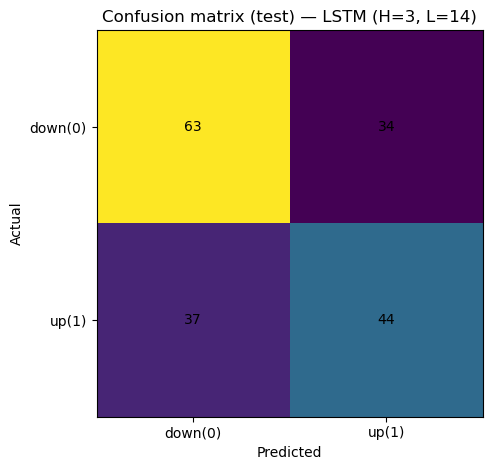

Saved: outputs/figures/lstm_confusion_H3_L14.png


In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title(f"Confusion matrix (test) — LSTM (H={H}, L={LOOKBACK})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["down(0)", "up(1)"])
plt.yticks([0, 1], ["down(0)", "up(1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()

cm_path = os.path.join(OUT_FIG_DIR, f"lstm_confusion_H{H}_L{LOOKBACK}.png")
plt.savefig(cm_path)
plt.show()
print("Saved:", cm_path)

In [ ]:
# ROC + AUC
auc = roc_auc_score(y_true, proba_up)
fpr, tpr, _ = roc_curve(y_true, proba_up)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC curve (test) — LSTM (H={H}, L={LOOKBACK})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()

roc_path = os.path.join(OUT_FIG_DIR, f"lstm_roc_H{H}_L{LOOKBACK}.png")
plt.savefig(roc_path)
plt.show()
print("Saved:", roc_path)

print("Test AUC:", round(float(auc), 3))


In [ ]:
# Save predictions (use meta_test to keep date + ticker aligned)
preds = meta_test[["date", "ticker_id"]].copy()
preds["proba_up"] = proba_up
preds["pred_up"] = y_pred
preds["actual_up"] = y_true
preds["correct"] = (preds["pred_up"] == preds["actual_up"]).astype(int)

preds = preds.sort_values(["date", "ticker_id"]).reset_index(drop=True)

out_csv = os.path.join(OUT_PRED_DIR, f"lstm_predictions_H{H}_L{LOOKBACK}.csv")
preds.to_csv(out_csv, index=False)
print("Saved:", out_csv)

preds.head()
